# 1. Import data and packages

In [1]:
# Import packages
import numpy as np
import pandas as pd
import datetime as dt
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm

In [2]:
# Set figure parameters
plt.rcParams['figure.figsize'] = [8,4]

In [3]:
# Import data
day_ahead_prices_df = pd.read_csv('.\Data\Final\day_ahead_final.csv', sep=';', header=0, index_col=0)
daily_prices_df = pd.read_csv('.\Data\Final\daily_prices_final.csv', sep=';', header=0, index_col=0)
generation_df = pd.read_csv('.\Data\Final\generation_final.csv', sep=';', header=0, index_col=0)
production_type_df = pd.read_csv('.\Data\Final\production_type_final.csv', sep=';', header=0, index_col=0)
load_df = pd.read_csv('.\Data\Final\load_final.csv', sep=';', header=0, index_col=0)
outages_df = pd.read_csv('.\Data\Final\outages_final.csv', sep=';', header=0, index_col=0)
import_df = pd.read_csv('.\Data\Final\import_final.csv', sep=';', header=0, index_col=0)

In [4]:
# Check dfs
print(day_ahead_prices_df.shape)
print(daily_prices_df.shape)
print(generation_df.shape)
print(production_type_df.shape)
print(load_df.shape)
print(outages_df.shape)
print(import_df.shape)

(52584, 1)
(1896, 2)
(52584, 47)
(52584, 12)
(52584, 1)
(2463, 9)
(52584, 4)


In [5]:
# Check date types
print(day_ahead_prices_df.dtypes)
print(daily_prices_df.dtypes)
print(generation_df.dtypes)
print(production_type_df.dtypes)
print(load_df.dtypes)
print(outages_df.dtypes)
print(import_df.dtypes)

day_ahead_price    float64
dtype: object
day_ahead_price    float64
gas_price          float64
dtype: object
Amercoeur 1 R GT                    float64
Amercoeur 1 R ST                    float64
Belwind Phase 1                     float64
COO 1 T                             float64
COO 2 T                             float64
COO 3 T                             float64
COO 4 T                             float64
COO 5 T                             float64
COO 6 T                             float64
DOEL 1                              float64
DOEL 2                              float64
DOEL 3                              float64
DOEL 4                              float64
DROGENBOS GT1                       float64
DROGENBOS GT2                       float64
DROGENBOS ST                        float64
EDF Luminus Seraing GT1             float64
EDF Luminus Seraing GT2             float64
HERDERSBRUG GT1                     float64
HERDERSBRUG GT2                     float64
HERDERSBRUG

In [6]:
# Dates to datetime
day_ahead_prices_df.index = pd.to_datetime(day_ahead_prices_df.index, utc=True).tz_convert('CET')
daily_prices_df.index = pd.to_datetime(daily_prices_df.index, utc=True).tz_convert('CET')
generation_df.index = pd.to_datetime(generation_df.index, utc=True).tz_convert('CET')
production_type_df.index = pd.to_datetime(production_type_df.index, utc=True).tz_convert('CET')
load_df.index = pd.to_datetime(load_df.index, utc=True).tz_convert('CET')
outages_df['start'] = pd.to_datetime(outages_df['start'], utc=True).dt.tz_convert('CET')
outages_df['end'] = pd.to_datetime(outages_df['end'], utc=True).dt.tz_convert('CET')
outages_df['outage_time'] = pd.to_timedelta(outages_df['outage_time'])
import_df.index = pd.to_datetime(import_df.index, utc=True).tz_convert('CET')

In [7]:
# Check
daily_prices_df.head(5)

,day_ahead_price,gas_price
date,,
2017-10-23 00:00:00+02:00,65.805000,18.09
2017-10-24 00:00:00+02:00,52.650000,17.96
2017-10-25 00:00:00+02:00,58.244167,18.11
2017-10-26 00:00:00+02:00,64.522917,18.07
2017-10-27 00:00:00+02:00,53.442083,18.15


# 2. Descriptive Analysis

## 2.1 Evolution prices

In [8]:
# Summary statistics
daily_prices_df.describe()

,day_ahead_price,gas_price
count,1896.000000,1896.000000
mean,93.706426,44.177020
std,99.716494,52.346711
min,-133.560833,3.510000
25%,37.369375,14.230000
50%,51.881250,20.080000
75%,96.881458,61.772500
max,700.412917,339.195000


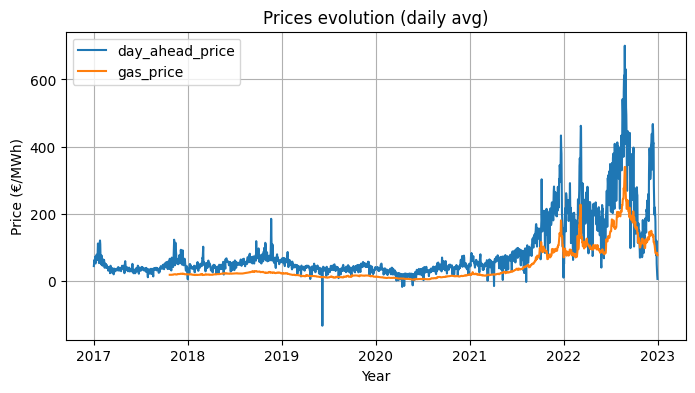

In [10]:
# Get evolution
plt.plot(day_ahead_prices_df.resample('D').mean().index, day_ahead_prices_df.resample('D').mean()['day_ahead_price'], label='day_ahead_price')
plt.plot(daily_prices_df.index, daily_prices_df['gas_price'], label='gas_price')
    
plt.xlabel('Year')
plt.ylabel('Price (€/MWh)')
plt.title('Prices evolution (daily avg)')
plt.legend(loc='upper left')

plt.grid(visible=True, which='both', axis='both')

plt.show()

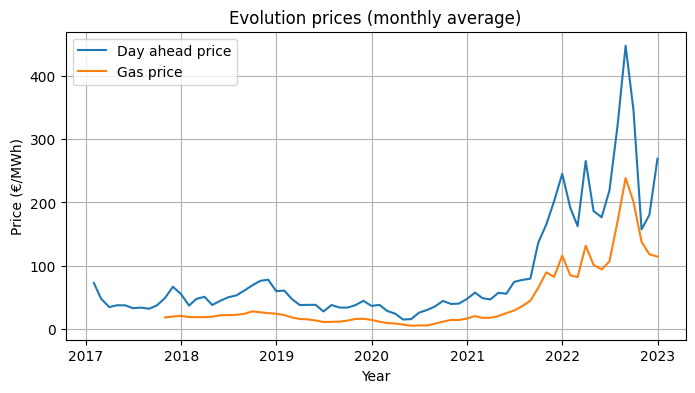

In [11]:
# Get evolution (resampled per month)
plt.plot(day_ahead_prices_df.resample('M').mean().index, day_ahead_prices_df.resample('M').mean()['day_ahead_price'], label='Day ahead price')
plt.plot(daily_prices_df.resample('M').mean().index, daily_prices_df.resample('M').mean()['gas_price'], label='Gas price')
    
plt.xlabel('Year')
plt.ylabel('Price (€/MWh)')
plt.title('Evolution prices (monthly average)')
plt.legend(loc='upper left')

plt.grid(visible=True, which='both', axis='both')

#plt.savefig('evolution_prices_monthly.png', bbox_inches='tight')

plt.show()

## 2.2 Relationship gas and electricity price

In [12]:
# Number of data points gas and electricity prices
print(daily_prices_df.shape)

(1896, 2)


In [13]:
# Normalize values
X = daily_prices_df['gas_price'].values.reshape(-1,1)
y = daily_prices_df['day_ahead_price'].values.reshape(-1,1)

In [14]:
# Fit Linear Regression
reg = LinearRegression()
reg.fit(X, y)

LinearRegression()

In [15]:
# Model
print("The linear model is: Y = {:.5} + {:.5}X".format(reg.intercept_[0], reg.coef_[0][0]))

The linear model is: Y = 15.523 + 1.7698X


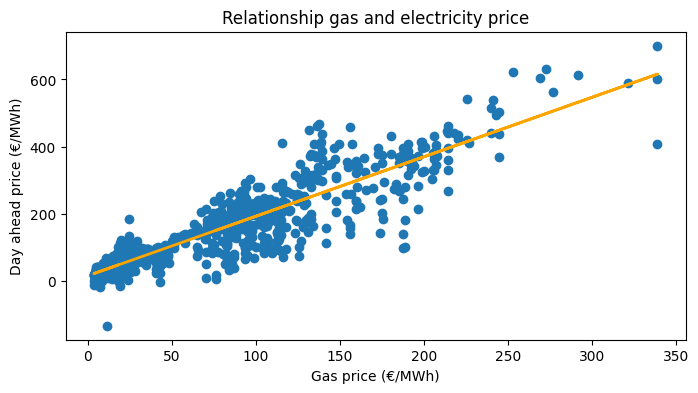

In [16]:
# Visualise
predictions = reg.predict(X)

plt.scatter(x=daily_prices_df['gas_price'], y=daily_prices_df['day_ahead_price'])
plt.plot(daily_prices_df['gas_price'], predictions, c='orange', linewidth=2)

plt.xlabel('Gas price (€/MWh)')
plt.ylabel('Day ahead price (€/MWh)')
plt.title('Relationship gas and electricity price')

#plt.savefig('prices_regr.png', bbox_inches='tight')

plt.show()

In [17]:
# Get correlation
round(daily_prices_df['gas_price'].corr(daily_prices_df['day_ahead_price']),2)

0.93

## 2.3 Generation per generation unit

In [19]:
# List of fossil gas plants (list copied from Data_Cleaning)
fossil_gas_cols = ['Amercoeur 1 R GT', 'Amercoeur 1 R ST', 'DROGENBOS GT1', 'DROGENBOS GT2', 'DROGENBOS ST', 'EDF Luminus Seraing GT1', 'EDF Luminus Seraing GT2', 'HERDERSBRUG GT1', 'HERDERSBRUG GT2', 'HERDERSBRUG ST', 'INESCO WKK', 'Marcinelle Energie (Carsid)', 'RINGVAART STEG', 'SAINT-GHISLAIN STEG', 'SERAING TV', 'Scheldelaan Exxonmobil', 'T-power Beringen', 'VILVOORDE GT', 'VILVOORDE ST', 'Zandvliet Power', 'Zelzate 2 Knippegroen']

In [20]:
# Create df with FG generation plants
generation_fg_df = generation_df.loc[:, fossil_gas_cols]

In [21]:
# Create total generation by 1 STEG/TGV plant (fe sum GT and ST of Amercoeur (GT=GasTurbine, ST=SteamTurbine))
generation_fg_df['Amercoeur 1 R TGV'] = generation_fg_df['Amercoeur 1 R GT'] + generation_fg_df['Amercoeur 1 R ST']
generation_fg_df['DROGENBOS TGV'] = generation_fg_df['DROGENBOS GT1'] + generation_fg_df['DROGENBOS GT2'] + generation_fg_df['DROGENBOS ST']
generation_fg_df['EDF Luminus Seraing TGV'] = generation_fg_df['EDF Luminus Seraing GT1'] + generation_fg_df['EDF Luminus Seraing GT2'] + generation_fg_df['SERAING TV']
generation_fg_df['HERDERSBRUG STEG'] = generation_fg_df['HERDERSBRUG GT1'] + generation_fg_df['HERDERSBRUG GT2'] + generation_fg_df['HERDERSBRUG ST']
generation_fg_df['VILVOORDE TGV'] = generation_fg_df['VILVOORDE GT'] + generation_fg_df['VILVOORDE ST']

In [22]:
# Drop unnecessary columns
generation_fg_df = generation_fg_df.drop(['Amercoeur 1 R GT', 'Amercoeur 1 R ST', 'DROGENBOS GT1', 'DROGENBOS GT2', 'DROGENBOS ST', 'EDF Luminus Seraing GT1', 'EDF Luminus Seraing GT2', 'SERAING TV', 'HERDERSBRUG GT1', 'HERDERSBRUG GT2', 'HERDERSBRUG ST', 'VILVOORDE GT', 'VILVOORDE ST'], axis=1)

In [23]:
# Fossil gas plants
generation_fg_df.describe()

,INESCO WKK,Marcinelle Energie (Carsid),RINGVAART STEG,SAINT-GHISLAIN STEG,Scheldelaan Exxonmobil,T-power Beringen,Zandvliet Power,Zelzate 2 Knippegroen,Amercoeur 1 R TGV,DROGENBOS TGV,EDF Luminus Seraing TGV,HERDERSBRUG STEG,VILVOORDE TGV
count,52584.000000,52584.00000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000
mean,81.321866,159.47562,184.926156,137.367317,83.858189,254.015499,213.829625,240.121387,253.380230,112.118819,95.272668,94.043740,19.711319
std,28.554057,182.71741,146.167004,147.884657,35.694987,159.192832,169.717181,83.688668,166.640815,164.676572,171.951122,152.875327,77.292186
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.00000,0.000000,0.000000,75.000000,1.000000,0.000000,225.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,94.000000,0.00000,242.000000,4.000000,90.000000,329.000000,336.000000,275.000000,307.000000,0.000000,0.000000,0.000000,0.000000
75%,101.000000,380.00000,313.000000,297.000000,108.000000,376.000000,361.000000,295.000000,397.000000,213.000000,103.000000,183.000000,0.000000
max,142.000000,404.00000,386.000000,385.000000,138.000000,436.000000,390.000000,321.000000,458.000000,495.000000,506.000000,501.000000,389.000000


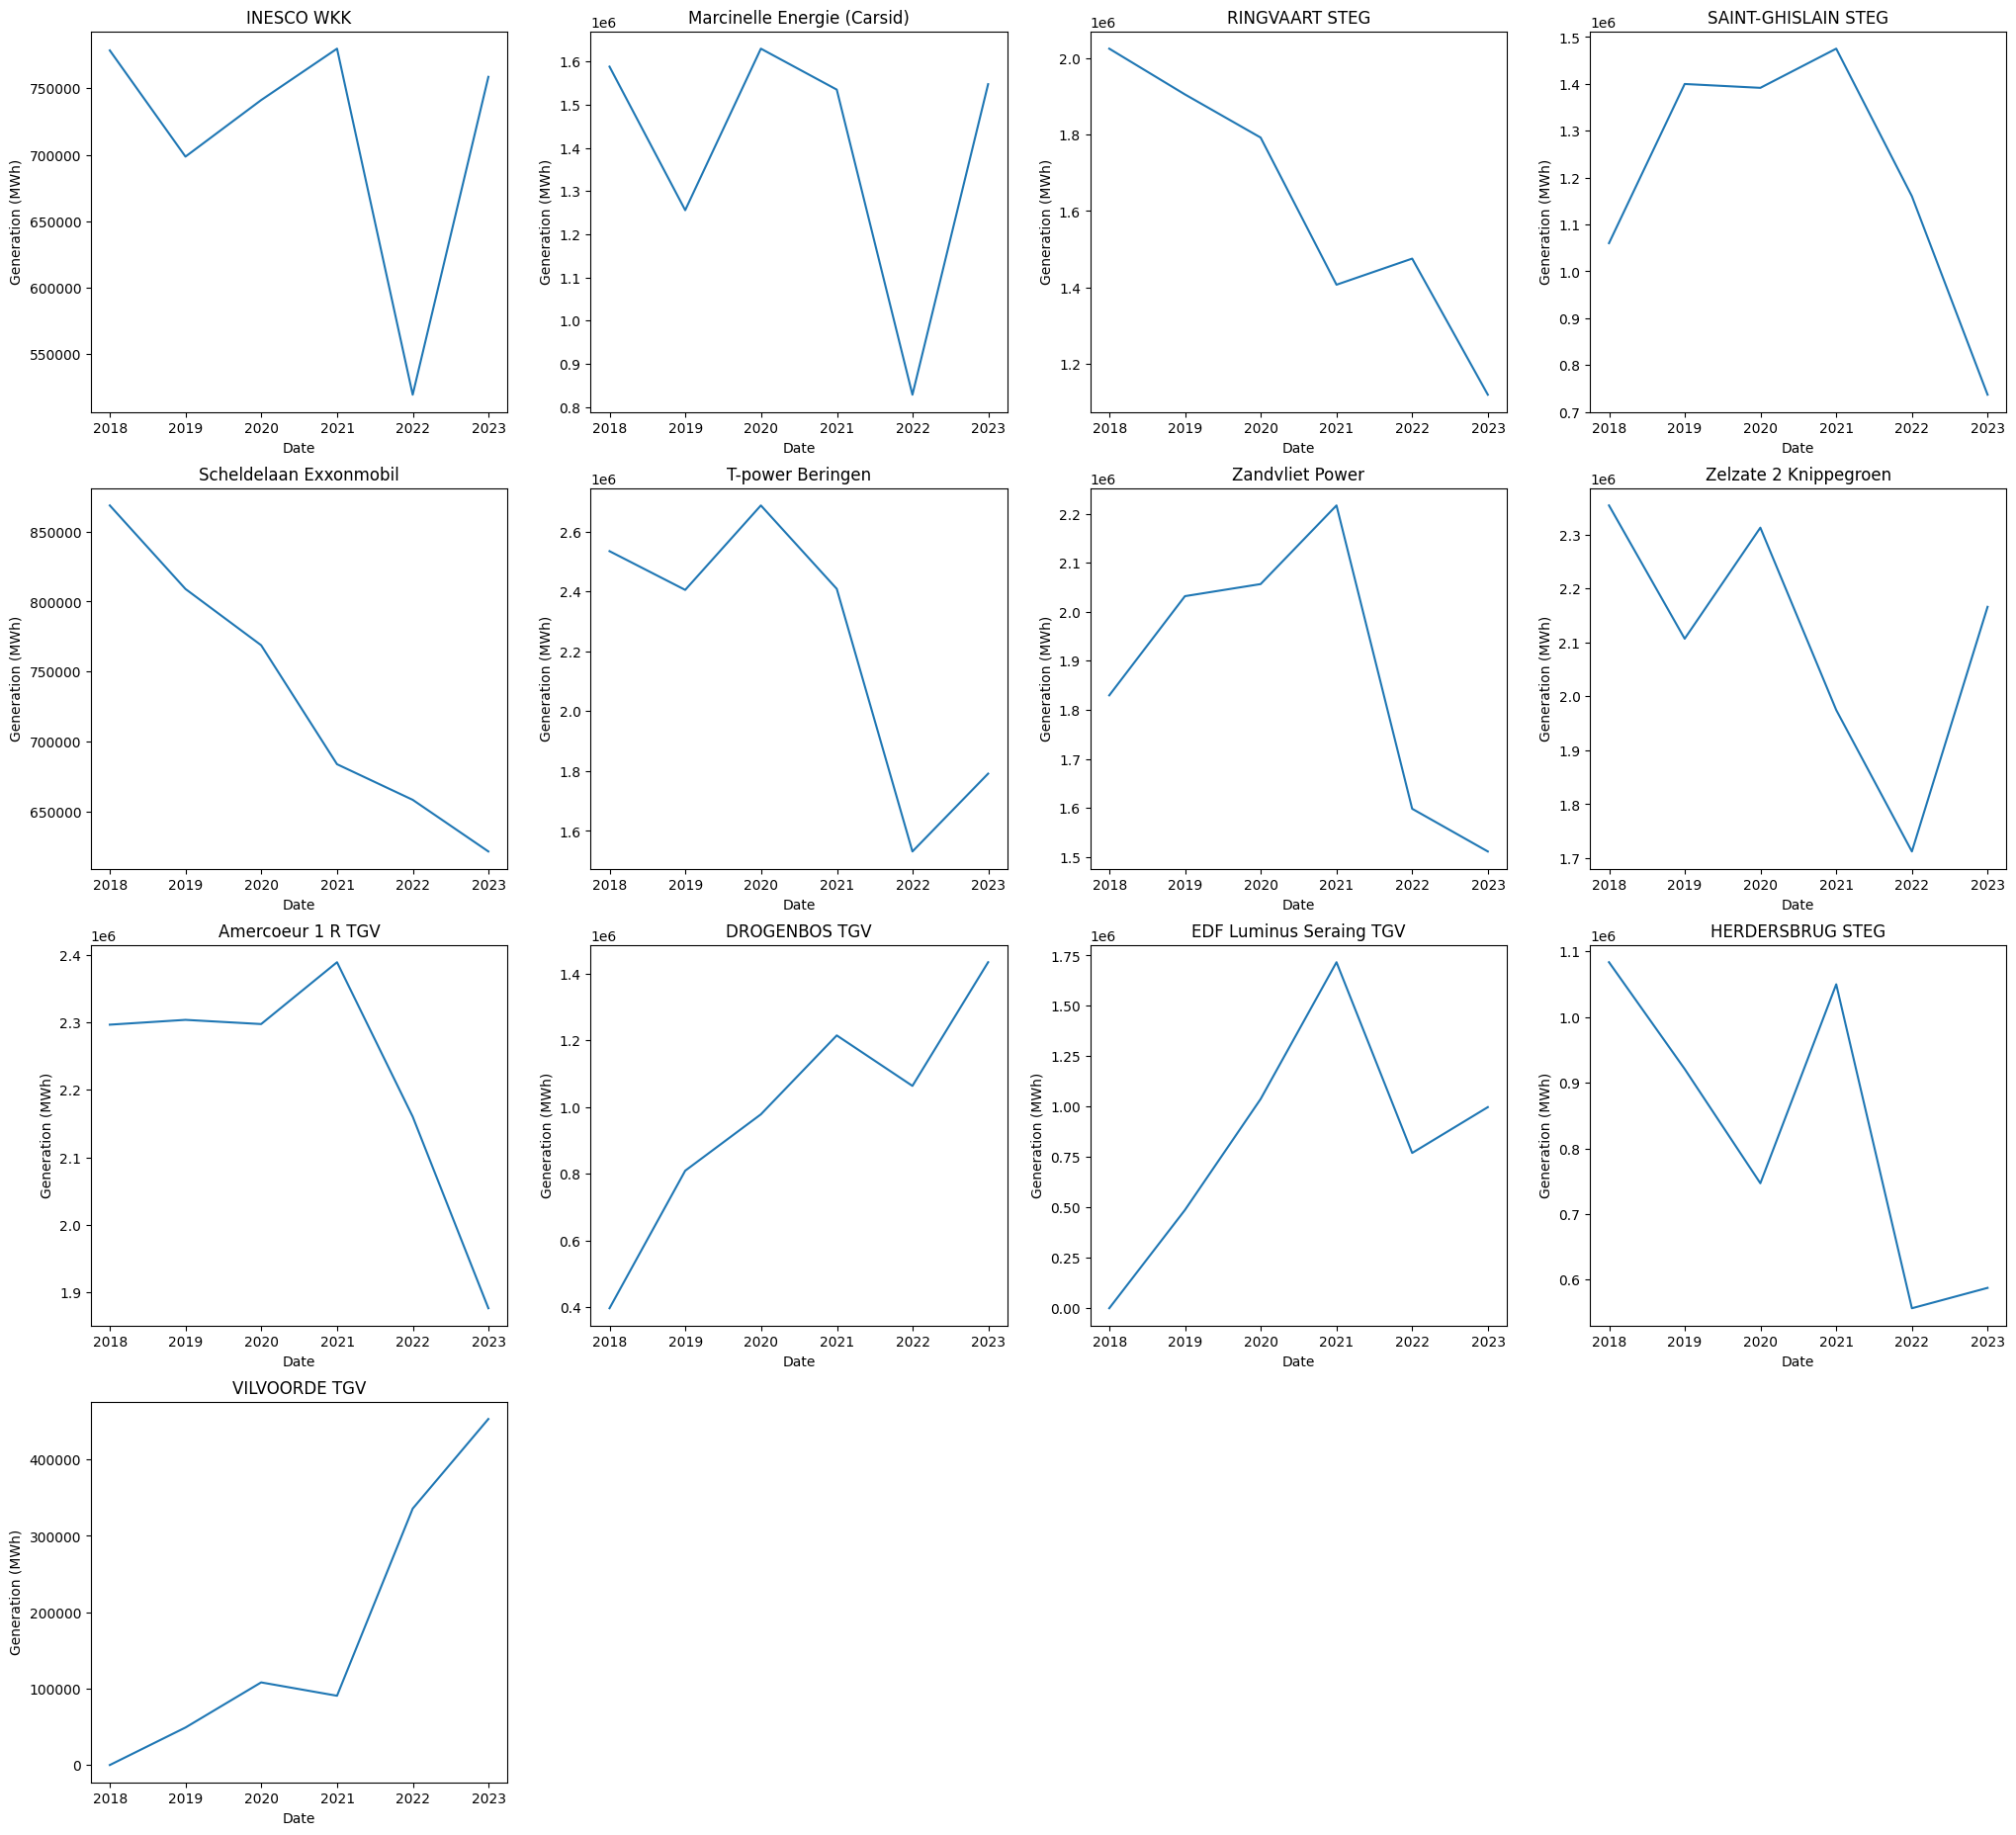

In [24]:
# Plot evolution of yearly generation individually
plt.figure(figsize=(25,35))

for i, col in enumerate(generation_fg_df.columns):
    plt.subplot(6,4,i+1)
    plt.plot(generation_fg_df.resample('Y').sum().index, generation_fg_df.resample('Y').sum()[col])
    plt.xlabel('Date')
    plt.ylabel('Generation (MWh)')
    plt.title(col)

plt.show()

## 2.4 Production per type

In [25]:
# Summary for each type 
production_type_df.describe()

,Biomass,Fossil Gas,Fossil Oil,Hydro Pumped Storage,Hydro Run-of-river and poundage,Nuclear,Other,Solar,Waste,Wind Offshore,Wind Onshore,Fossil Hard coal
count,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.000000,52584.0
mean,270.759813,2482.893504,0.612049,116.889986,17.431215,4399.816389,618.151168,481.639263,237.827077,588.656264,407.042237,0.0
std,89.594339,1031.787817,7.137977,211.040846,13.378383,1109.349045,147.463885,795.411848,28.339240,608.173937,393.880150,0.0
min,20.000000,436.000000,0.000000,0.000000,0.000000,1005.000000,74.000000,0.000000,118.000000,0.000000,1.000000,0.0
25%,247.000000,1606.000000,0.000000,0.000000,5.000000,3884.000000,512.000000,0.000000,223.000000,85.000000,113.000000,0.0
50%,290.000000,2332.000000,0.000000,0.000000,14.000000,4787.000000,637.000000,10.000000,242.000000,368.000000,272.000000,0.0
75%,340.000000,3218.000000,0.000000,132.000000,29.000000,4994.000000,730.000000,697.000000,257.000000,892.000000,575.000000,0.0
max,403.000000,5587.000000,169.000000,1158.000000,52.000000,6018.000000,1065.000000,4567.000000,317.000000,2195.000000,2418.000000,0.0


In [26]:
# Sum similar sources
production_type_df['Hydro'] = production_type_df['Hydro Run-of-river and poundage']
production_type_df['Wind'] = production_type_df['Wind Offshore'] + production_type_df['Wind Onshore']

In [27]:
# Drop Fossil Hard Coal, Hydro Pumped Storage, Hydro Run-of-river, Wind offshore and Wind onshore
production_type_df.drop(['Hydro Pumped Storage', 'Hydro Run-of-river and poundage', 'Wind Offshore', 'Wind Onshore', 'Fossil Hard coal'], axis=1, inplace=True)

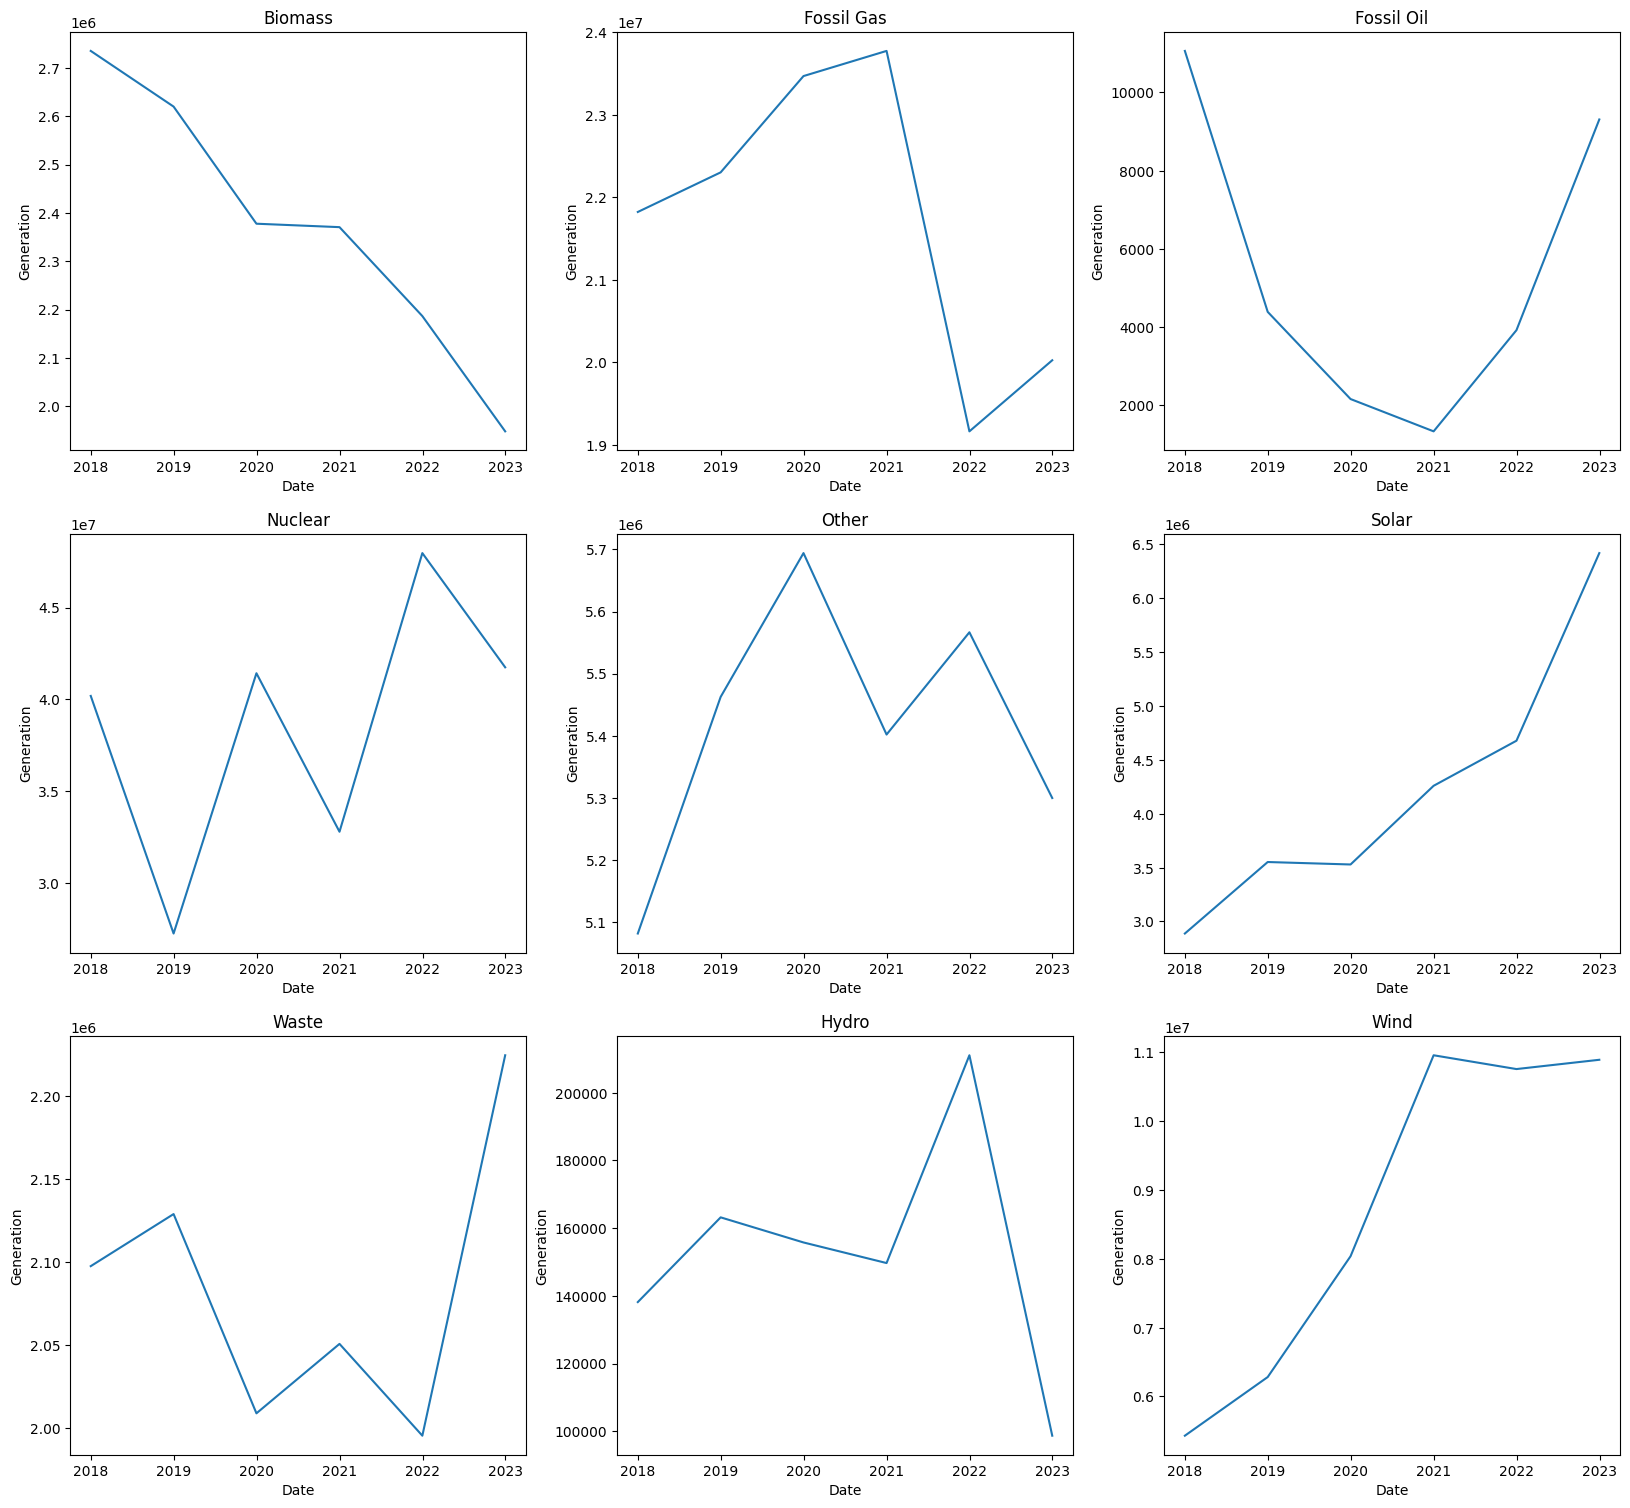

In [28]:
# Plot evolution of monthly generation per type individually
plt.figure(figsize=(20,25))

for i, col in enumerate(production_type_df.columns):
    plt.subplot(4,3,i+1)
    plt.plot(production_type_df.resample('Y').sum().index, production_type_df.resample('Y').sum()[col])
    plt.xlabel('Date')
    plt.ylabel('Generation')
    plt.title(col)

plt.show()

In [29]:
# Create yearly production per type (in TWh)
yearly_production_type_df = production_type_df.resample('Y').sum()/1000000

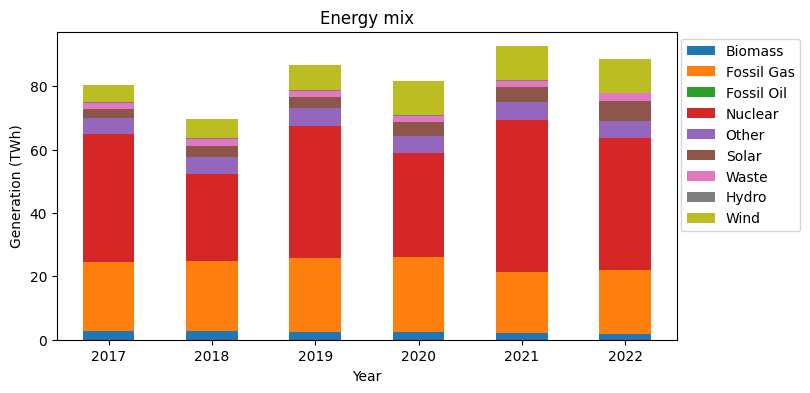

In [30]:
# Stacked bar chart (x: years, y: production per type)
yearly_production_type_df.plot(kind='bar', stacked=True)

plt.xticks(np.arange(6), yearly_production_type_df.index.year, rotation=0)
plt.xlabel('Year')
plt.ylabel('Generation (TWh)')
plt.title('Energy mix')
plt.legend(loc='upper right', bbox_to_anchor=(1.21, 1.0))

#plt.savefig('production_yearly_stacked.png', bbox_inches='tight')

plt.show()

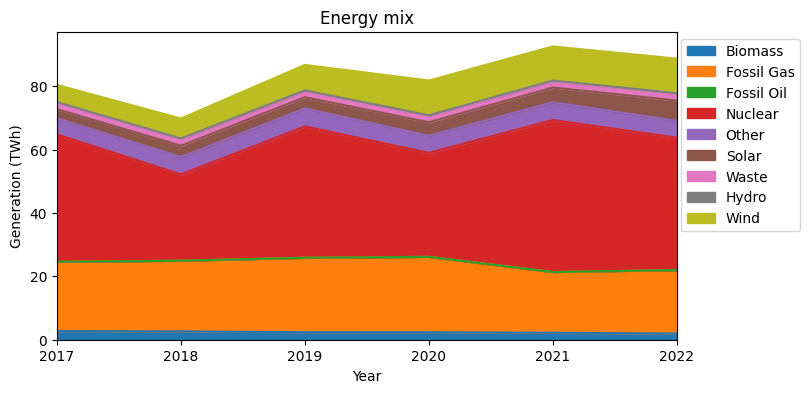

In [31]:
# Area plot
yearly_production_type_df.plot.area()

plt.xlabel('Year')
plt.ylabel('Generation (TWh)')
plt.title('Energy mix')
plt.legend(loc='upper right', bbox_to_anchor=(1.21, 1.0))

#plt.savefig('production_yearly_area.png', bbox_inches='tight')

plt.show()

In [32]:
# Create table
total_generation_df = pd.DataFrame(production_type_df.sum(axis=1), columns=['Total generation (MWh)'])
importance_df = total_generation_df.join(load_df) \
                                   .join(production_type_df[['Fossil Gas']])

In [33]:
# Create percentages
importance_df['FG_TotalGeneration'] = round(importance_df['Fossil Gas']/importance_df['Total generation (MWh)'],2)
importance_df['FG_Load'] = round(importance_df['Fossil Gas']/importance_df['Actual Load'],2)

In [34]:
# Check
importance_df.head(5)

,Total generation (MWh),Actual Load,Fossil Gas,FG_TotalGeneration,FG_Load
date,,,,,
2017-01-01 00:00:00+01:00,9191.0,10108.75,2462.0,0.27,0.24
2017-01-01 01:00:00+01:00,9056.0,9771.50,2334.0,0.26,0.24
2017-01-01 02:00:00+01:00,8941.0,9354.00,2197.0,0.25,0.23
2017-01-01 03:00:00+01:00,8963.0,8979.75,2249.0,0.25,0.25
2017-01-01 04:00:00+01:00,8761.0,8676.00,1952.0,0.22,0.22


In [35]:
print(round(importance_df['FG_TotalGeneration'].mean(),2))
print(round(importance_df['FG_Load'].mean(),2))

0.26
0.25


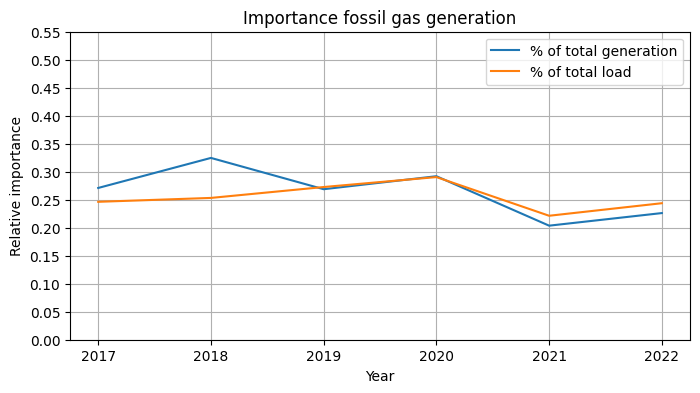

In [36]:
# Relative importance of FG generation in total generation and load

plt.plot(importance_df.resample('Y').mean().index.year, importance_df.resample('Y').mean()['FG_TotalGeneration'], label='% of total generation')
plt.plot(importance_df.resample('Y').mean().index.year, importance_df.resample('Y').mean()['FG_Load'], label='% of total load')

plt.xlabel('Year')
plt.yticks(np.arange(0, 0.6, 0.05))
plt.ylabel('Relative importance')
plt.title('Importance fossil gas generation')
plt.legend(loc='upper right')

plt.grid(visible=True, which='both', axis='both')

#plt.savefig('perc_FG_generation.png', bbox_inches='tight')

plt.show()

## 2.5 Outages

In [37]:
# Check
outages_df.head(5)

,start,end,production_resource_name,plant_type,avail_qty,nominal_power,businesstype,year_outage,outage_time
0,2016-04-01 00:00:00+02:00,2017-01-01 00:00:00+01:00,LANGERLO 1,Fossil Hard coal,0.0,235.0,Planned maintenance,2016,275 days 01:00:00
1,2016-04-01 00:00:00+02:00,2017-01-01 00:00:00+01:00,LANGERLO 2,Fossil Hard coal,0.0,235.0,Planned maintenance,2016,275 days 01:00:00
2,2016-04-01 00:00:00+02:00,2017-01-01 00:00:00+01:00,LANGERLO 1,Fossil Hard coal,0.0,235.0,Planned maintenance,2016,275 days 01:00:00
3,2016-04-01 00:00:00+02:00,2017-01-01 00:00:00+01:00,LANGERLO 2,Fossil Hard coal,0.0,235.0,Planned maintenance,2016,275 days 01:00:00
4,2016-12-16 00:00:00+01:00,2017-01-01 00:00:00+01:00,T-power Beringen,Fossil Gas,0.0,419.8,Planned maintenance,2016,16 days 00:00:00


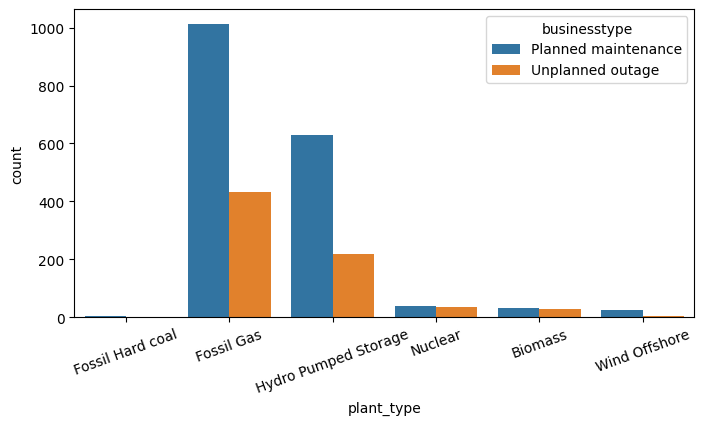

In [38]:
# Inspect frequency counts of outage types
sns.countplot(x=outages_df['plant_type'], hue=outages_df['businesstype'])
plt.xticks(rotation=20)
plt.show()

# 3. Analysis prices

In [39]:
# If necessary, set data from 2017-10-23 as subset dfs (use when combining with gas price)
day_ahead_prices_subset_df = day_ahead_prices_df['2017-10-23':]
generation_subset_df = generation_df['2017-10-23':]
production_type_subset_df = production_type_df['2017-10-23':]
import_subset_df = import_df['2017-10-23':]
load_subset_df = load_df['2017-10-23':]

In [40]:
# Join day ahead and gas price (per hour)
hourly_prices_df = day_ahead_prices_subset_df.join(daily_prices_df.drop(['day_ahead_price'], axis=1)).fillna(method='ffill')

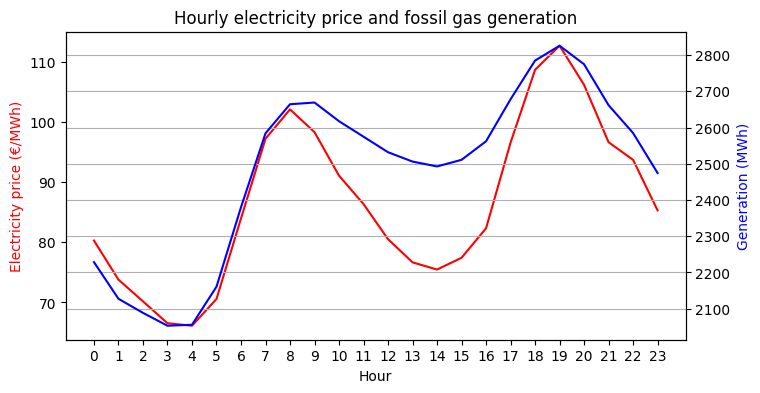

In [41]:
# Create plot to inspect electricity price and fossil gas generation per hour
fig, ax = plt.subplots()

ax.plot(day_ahead_prices_df.groupby(day_ahead_prices_df.index.hour)['day_ahead_price'].mean(), color='red')
ax.set_xlabel('Hour')
ax.set_xticks(np.arange(24))
ax.set_ylabel('Electricity price (€/MWh)', color='red')

ax2 = ax.twinx()
ax2.plot(production_type_df.groupby(production_type_df.index.hour)['Fossil Gas'].mean(), color='blue')
ax2.set_ylabel('Generation (MWh)', color='blue')

plt.grid(visible=True, which='both', axis='both')
plt.title('Hourly electricity price and fossil gas generation')
#plt.savefig('hourly_graphs.png', bbox_inches='tight')

plt.show()

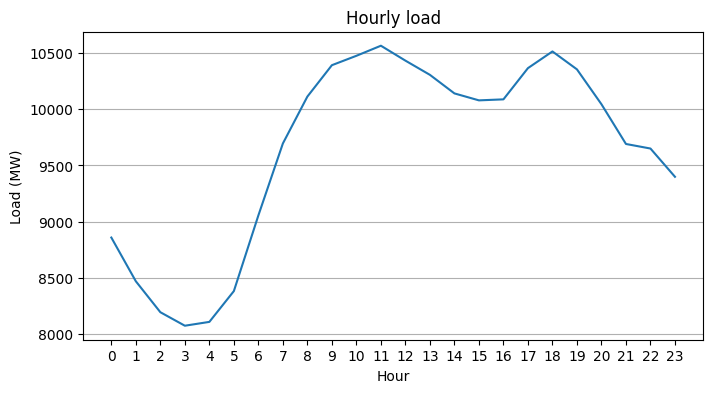

In [42]:
# Plot load evolution during the day
plt.plot(load_df.groupby(load_df.index.hour).mean())

plt.xlabel('Hour')
plt.xticks(np.arange(24))
plt.ylabel('Load (MW)')
plt.grid(visible=True, which='both', axis='y')
plt.title('Hourly load')

#plt.savefig('hourly_load.png', bbox_inches='tight')

plt.show()

## 3.1 FG and day ahead price

In [43]:
# Get correlation
round(production_type_df['Fossil Gas'].corr(day_ahead_prices_df['day_ahead_price']),2)

0.17

In [44]:
# Normalize values
X = production_type_df[['Fossil Gas']]
y = day_ahead_prices_df[['day_ahead_price']]

In [45]:
# Fit Linear Regression
linreg = LinearRegression()
linreg.fit(X, y)

LinearRegression()

In [46]:
# Model
print("The linear model is: Y = {:.5} + {:.5}X".format(linreg.intercept_[0], linreg.coef_[0][0]))

The linear model is: Y = 46.609 + 0.016106X


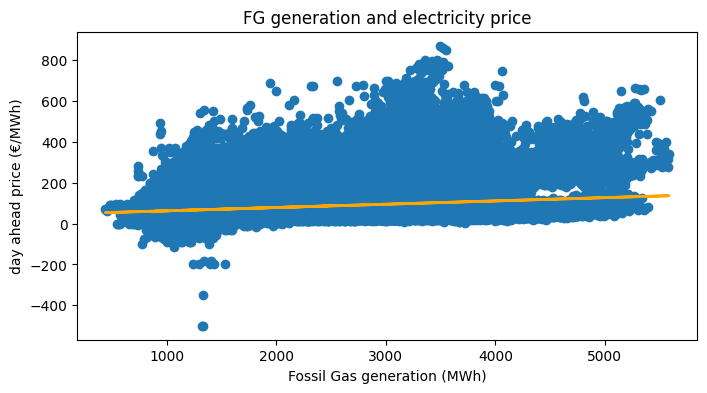

In [47]:
# Visualise
predictions = linreg.predict(X)

plt.scatter(x=production_type_df['Fossil Gas'], y=day_ahead_prices_df['day_ahead_price'])
plt.plot(production_type_df['Fossil Gas'], predictions, c='orange', linewidth=2)

plt.xlabel('Fossil Gas generation (MWh)')
plt.ylabel('day ahead price (€/MWh)')
plt.title('FG generation and electricity price')

plt.show()

## 3.2 Production types and day ahead price

In [52]:
# Add gas price
X = hourly_prices_df[['gas_price']].merge(production_type_subset_df, how='inner', on='date')
y = day_ahead_prices_subset_df[['day_ahead_price']]

In [53]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        day_ahead_price   R-squared:                       0.852
Model:                            OLS   Adj. R-squared:                  0.852
Method:                 Least Squares   F-statistic:                 2.618e+04
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:18:37   Log-Likelihood:            -2.3281e+05
No. Observations:               45505   AIC:                         4.656e+05
Df Residuals:                   45494   BIC:                         4.657e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -46.7353      2.072    -22.557      0.0

## 3.3 Multivariate Linear Regression

In [55]:
# Create total import
total_import_df = pd.DataFrame(import_subset_df.sum(axis=1), columns=['Total import'])

In [56]:
# Join all dataframes
basetable_df = hourly_prices_df[['gas_price']].merge(production_type_subset_df, how='inner', on='date') \
                                              .merge(total_import_df, how='inner', on='date') \
                                              .merge(load_subset_df, how='inner', on='date')

In [57]:
# Check
basetable_df.head(5)

,gas_price,Biomass,Fossil Gas,Fossil Oil,Nuclear,Other,Solar,Waste,Hydro,Wind,Total import,Actual Load
date,,,,,,,,,,,,
2017-10-23 00:00:00+02:00,18.09,345.0,1778.0,0.0,3953.0,412.0,0.0,269.0,8.0,1293.0,1942.0,8320.25
2017-10-23 01:00:00+02:00,18.09,348.0,1756.0,0.0,3954.0,392.0,0.0,269.0,8.0,1310.0,2369.0,7957.75
2017-10-23 02:00:00+02:00,18.09,344.0,1784.0,0.0,3952.0,407.0,0.0,267.0,8.0,1282.0,2373.0,7751.25
2017-10-23 03:00:00+02:00,18.09,344.0,1714.0,0.0,3954.0,435.0,0.0,268.0,8.0,1243.0,2528.0,7700.75
2017-10-23 04:00:00+02:00,18.09,345.0,1884.0,0.0,3956.0,395.0,0.0,268.0,8.0,1235.0,2549.0,7853.50


In [58]:
# Create variables
X = basetable_df
y = day_ahead_prices_subset_df[['day_ahead_price']]

In [59]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:        day_ahead_price   R-squared:                       0.857
Model:                            OLS   Adj. R-squared:                  0.857
Method:                 Least Squares   F-statistic:                 2.273e+04
Date:                Fri, 02 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:19:50   Log-Likelihood:            -2.3202e+05
No. Observations:               45505   AIC:                         4.641e+05
Df Residuals:                   45492   BIC:                         4.642e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const          -77.6377      2.258    -34.384   